# FCNN for segmentation and simple CNN to determine presence/abcence

In [2]:
import warnings
import exceptions
warnings.filterwarnings('ignore', category=exceptions.DeprecationWarning, module='.*/IPython/.*')

import os
import numpy as np
import glob
import cv2
import utils
import pylab as pl
import shutil
import matplotlib.cm as cm
from sklearn.cross_validation import train_test_split

%matplotlib inline

In [14]:
_d = np.load('../../data_train.npz')
X = _d['X']
Y = _d['Y']

In [15]:
print X.shape
print Y.shape

(5635, 104, 144)
(5635, 104, 144)


In [16]:
nsamples = X.shape[0]

train_indices, test_indices = train_test_split(np.arange(nsamples), test_size=0.1)
#train_indices, test_indices = train_test_split(np.arange(nsamples), test_size=0.25)
X_train = X[train_indices][:,None,:,:]
Y_train = Y[train_indices][:,None,:,:]
X_test = X[test_indices][:,None,:,:]
Y_test = Y[test_indices][:,None,:,:]

In [17]:
print X_train.shape
print Y_train.shape
print Y_test.shape
print X_train.min(), X_train.max()

(5071, 1, 104, 144)
(5071, 1, 104, 144)
(564, 1, 104, 144)
0.0 1.0


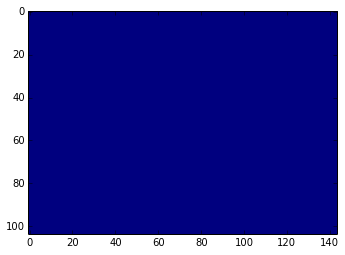

In [18]:
#pl.imshow(X_train[0].squeeze())
pl.imshow(Y_train[0].squeeze())

In [10]:
os.environ['KERAS_BACKEND'] = 'theano'
# TODO: Use float16 ?
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float16'
import keras
from keras.layers import Input, Dense, Dropout, Activation, Flatten, merge, RepeatVector, Permute, Reshape
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers import LeakyReLU
from keras.models import Model
from keras.optimizers import SGD, RMSprop
from keras.utils.layer_utils import print_summary

Using Theano backend.
Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN 4007)


In [11]:
import theano
print theano.config.device

gpu0


# FCNN trained only on positive examples

In [12]:
# channels first in keras
input_shape = X_train[0].shape
print input_shape

(1, 104, 144)


In [57]:
input_img = Input(shape=input_shape)
x = Convolution2D(16, 11, 11, border_mode='same')(input_img)
x = LeakyReLU()(x)
#x = Convolution2D(16, 3, 3, border_mode='same')(x)
#x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
pool1 = Dropout(0.25, name='pool1')(x)

x = Convolution2D(16, 7, 7, border_mode='same')(pool1)
x = LeakyReLU()(x)
#x = Convolution2D(32, 3, 3, border_mode='same')(x)
#x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
pool2 = Dropout(0.25, name='pool2')(x)

x = Convolution2D(16, 5, 5, border_mode='same')(pool2)
x = LeakyReLU()(x)
#x = Convolution2D(64, 3, 3, border_mode='same')(x)
#x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
pool3 = Dropout(0.25, name='pool3')(x)

x = Convolution2D(16, 3, 3, border_mode='same')(pool3)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)

x = merge([x, pool2], mode='sum')
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)

x = merge([x, pool1], mode='sum')
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)

outmap = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same', name='outmap')(x)

fcnn = Model(input_img, outmap)
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(optimizer=sgd, loss='binary_crossentropy')
#rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
#model.compile(optimizer=rmsprop, loss='binary_crossentropy')
fcnn.compile(optimizer='adam', loss='binary_crossentropy')

print_summary(fcnn.layers)

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_6 (InputLayer)               (None, 1, 104, 144) 0                                            
____________________________________________________________________________________________________
convolution2d_35 (Convolution2D)   (None, 16, 104, 144)1952        input_6[0][0]                    
____________________________________________________________________________________________________
leakyrelu_35 (LeakyReLU)           (None, 16, 104, 144)0           convolution2d_35[0][0]           
____________________________________________________________________________________________________
maxpooling2d_16 (MaxPooling2D)     (None, 16, 52, 72)  0           leakyrelu_35[0][0]               
___________________________________________________________________________________________

In [58]:
#from IPython.display import SVG
#from keras.utils.visualize_util import model_to_dot
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [59]:
# select only x with non-empty mask
valids_train = np.sum(np.sum(Y_train.squeeze(), axis=1), axis=1) > 0
_X_train = X_train[valids_train]
_Y_train = Y_train[valids_train]

valids_test = np.sum(np.sum(Y_test.squeeze(), axis=1), axis=1) > 0
_X_test = X_test[valids_test]
_Y_test = Y_test[valids_test]

print _X_train.shape
print _X_test.shape

(2066, 1, 104, 144)
(257, 1, 104, 144)


In [60]:
history = fcnn.fit(
    _X_train, _Y_train,
    batch_size=32,
    validation_data=(_X_test, _Y_test),
    nb_epoch=25 # 60
)

Train on 2066 samples, validate on 257 samples
Epoch 1/25
2066/2066 [==============================] - 8s - loss: 0.2091 - val_loss: 0.1852
Epoch 2/25
2066/2066 [==============================] - 8s - loss: 0.1148 - val_loss: 0.1367
Epoch 3/25
2066/2066 [==============================] - 7s - loss: 0.0803 - val_loss: 0.0828
Epoch 4/25
2066/2066 [==============================] - 7s - loss: 0.0657 - val_loss: 0.0754
Epoch 5/25
2066/2066 [==============================] - 8s - loss: 0.0586 - val_loss: 0.0617
Epoch 6/25
2066/2066 [==============================] - 8s - loss: 0.0537 - val_loss: 0.0577
Epoch 7/25
2066/2066 [==============================] - 8s - loss: 0.0511 - val_loss: 0.0532
Epoch 8/25
2066/2066 [==============================] - 8s - loss: 0.0496 - val_loss: 0.0542
Epoch 9/25
2066/2066 [==============================] - 8s - loss: 0.0484 - val_loss: 0.0523
Epoch 10/25
2066/2066 [==============================] - 8s - loss: 0.0471 - val_loss: 0.0475
Epoch 11/25
2066/2066 

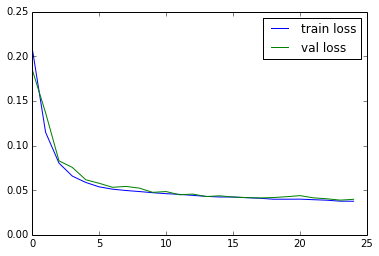

In [61]:
pl.plot(history.history['loss'], label='train loss')
pl.plot(history.history['val_loss'], c='g', label='val loss')
pl.legend()

In [99]:
def fcnn_predict(X):
    Y_pred = fcnn.predict(X)
    Y_pred = Y_pred > 0.5
    for i in range(Y_pred.shape[0]):
        # Clear prediction where we detect to little pixels
        # Figure it out by
        # pl.hist(np.sum(np.sum(np.sum(Y_pred, axis=1), axis=1), axis=1))
        if np.sum(Y_pred[i]) < 200:
            Y_pred[i,:] = 0
    return Y_pred

In [100]:
import utils
reload(utils)
Y_pred = fcnn_predict(X_test)
print "test set score : ", utils.dice_coefficient(Y_pred, Y_test)

test set score :  0.572217759838


In [104]:
if False:
    model_dir = '../../models/2models/fcnn'
    json_string = fcnn.to_json()
    open(os.path.join(model_dir, 'architecture.json'), 'w').write(json_string)
    fcnn.save_weights(os.path.join(model_dir, 'weights.h5'))

# CNN trained to determine nerve presence

In [127]:
input_img = Input(shape=input_shape)
x = Convolution2D(16, 3, 3,border_mode='valid')(input_img)
x = LeakyReLU()(x)
x = Convolution2D(16, 3, 3)(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)
pool1 = Dropout(0.25, name='pool1')(x)

x = Convolution2D(32, 3, 3, border_mode='valid')(pool1)
x = LeakyReLU()(x)
x = Convolution2D(16, 3, 3)(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)
pool2 = Dropout(0.25, name='pool2')(x)

x = Convolution2D(64, 3, 3, border_mode='valid')(pool2)
x = LeakyReLU()(x)
x = Convolution2D(16, 3, 3)(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)
pool3 = Dropout(0.25, name='pool3')(x)

x = Convolution2D(32, 3, 3, border_mode='valid')(pool3)
x = LeakyReLU()(x)
x = Convolution2D(16, 3, 3)(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)
pool4 = Dropout(0.25, name='pool4')(x)

# Since some images have not mask, the hope is that the innermost units capture this
x = Flatten()(pool4)
x = Dense(32)(x)
x = Dense(16)(x)
outpred = Dense(1, activation='sigmoid')(x)

binnn = Model(input_img, outpred)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
binnn.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
#binnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print_summary(binnn.layers)

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_20 (InputLayer)              (None, 1, 104, 144) 0                                            
____________________________________________________________________________________________________
convolution2d_124 (Convolution2D)  (None, 16, 102, 142)160         input_20[0][0]                   
____________________________________________________________________________________________________
leakyrelu_130 (LeakyReLU)          (None, 16, 102, 142)0           convolution2d_124[0][0]          
____________________________________________________________________________________________________
convolution2d_125 (Convolution2D)  (None, 16, 100, 140)2320        leakyrelu_130[0][0]              
___________________________________________________________________________________________

In [128]:
# Turn labels into boolean present/missing
Y_train_binary = np.sum(np.sum(Y_train.squeeze(), axis=2), axis=1) > 0
Y_train_binary = Y_train_binary.astype(np.float32)[:,None]

Y_test_binary = np.sum(np.sum(Y_test.squeeze(), axis=2), axis=1) > 0
Y_test_binary = Y_test_binary.astype(np.float32)[:,None]

print X_train.shape

history = binnn.fit(
    X_train, Y_train_binary,
    batch_size=32,
    validation_data=(X_test, Y_test_binary),
    nb_epoch=40 # 60
)

(5071, 1, 104, 144)
Train on 5071 samples, validate on 564 samples
Epoch 1/40
5071/5071 [==============================] - 21s - loss: 0.7098 - acc: 0.5918 - val_loss: 0.6446 - val_acc: 0.6596
Epoch 2/40
5071/5071 [==============================] - 20s - loss: 0.6337 - acc: 0.6535 - val_loss: 0.6058 - val_acc: 0.6844
Epoch 3/40
5071/5071 [==============================] - 20s - loss: 0.6128 - acc: 0.6744 - val_loss: 0.6029 - val_acc: 0.6933
Epoch 4/40
5071/5071 [==============================] - 20s - loss: 0.5932 - acc: 0.6892 - val_loss: 0.5756 - val_acc: 0.7145
Epoch 5/40
5071/5071 [==============================] - 20s - loss: 0.5798 - acc: 0.7007 - val_loss: 0.5833 - val_acc: 0.7004
Epoch 6/40
5071/5071 [==============================] - 21s - loss: 0.5630 - acc: 0.7176 - val_loss: 0.5510 - val_acc: 0.7234
Epoch 7/40
5071/5071 [==============================] - 16s - loss: 0.5463 - acc: 0.7292 - val_loss: 0.5595 - val_acc: 0.7039
Epoch 8/40
5071/5071 [=============================

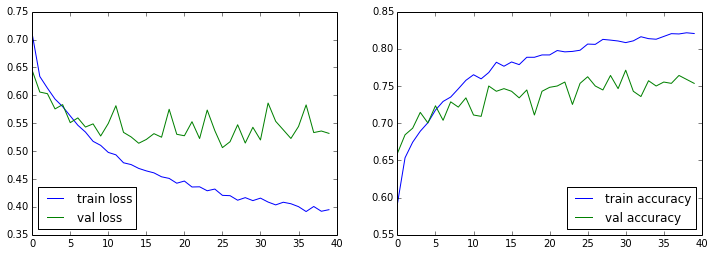

In [129]:
pl.figure(figsize=(12, 4))
pl.subplot(121)
pl.plot(history.history['loss'], label='train loss')
pl.plot(history.history['val_loss'], c='g', label='val loss')
pl.legend(loc='lower left')

pl.subplot(122)
pl.plot(history.history['acc'], label='train accuracy')
pl.plot(history.history['val_acc'], c='g', label='val accuracy')
pl.legend(loc='lower right')

In [131]:
def binnn_predict(X):
     return (binnn.predict(X) > 0.5).squeeze()
Y_pred = binnn_predict(X_test)

In [132]:
from sklearn.metrics import accuracy_score
print "test set score : ", accuracy_score(Y_test_binary, Y_pred)

test set score :  0.753546099291


In [135]:
if True:
    model_dir = '../../models/2models/binnn'
    json_string = fcnn.to_json()
    open(os.path.join(model_dir, 'architecture.json'), 'w').write(json_string)
    fcnn.save_weights(os.path.join(model_dir, 'weights.h5'))

In [69]:
# Find the images with lowest scores
dice_scores = []
for i in range(Y_pred.shape[0]):
    dice_scores.append(dice_coefficient(Y_pred[i], Y_test[i]))
dice_scores = np.array(dice_scores)
lowest = np.argsort(dice_scores)

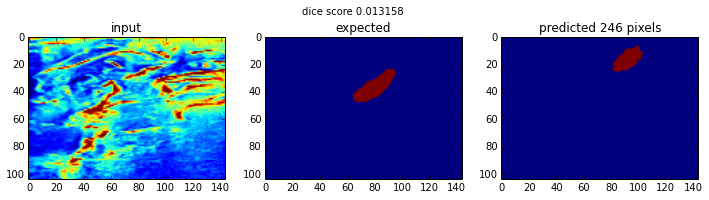

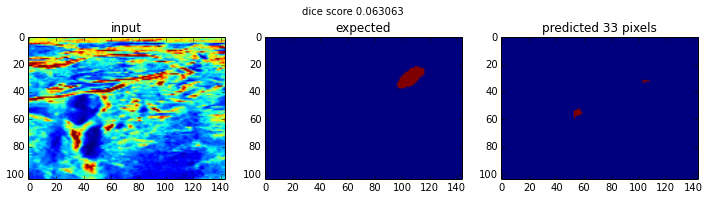

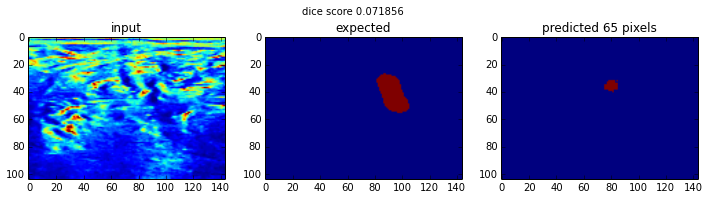

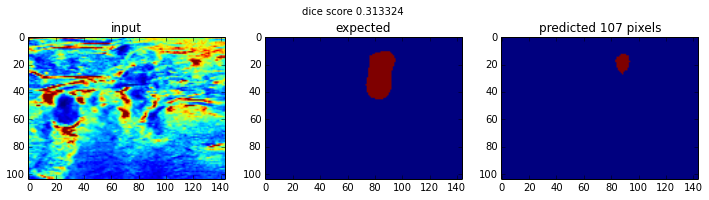

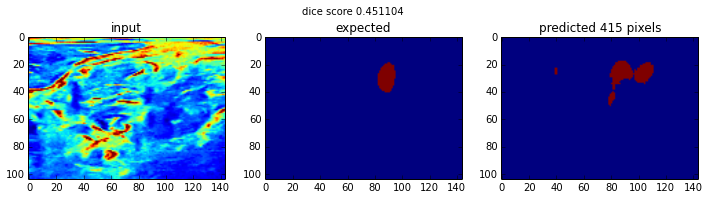

In [70]:
#i = 50
#i = 47

#for i in lowest[-1050:-1045]:
for i in lowest[5:10]:
    pl.figure(figsize=(12, 3))
    pl.suptitle('dice score %f' % dice_coefficient(Y_pred[i], Y_test[i]))
    pl.subplot(131)
    pl.title('input')
    pl.imshow(X_test[i].squeeze())
    pl.subplot(132)
    pl.title('expected')
    pl.imshow(Y_test[i].squeeze())
    pl.subplot(133)
    pl.title('predicted %d pixels' % np.sum(Y_pred[i]))
    pl.imshow(Y_pred[i].squeeze(), vmin=0, vmax=1)

# Run the model on kaggle'7 test set

In [50]:
_d = np.load('../../data_test.npz')
X_submit = _d['X']
test_fnames = _d['test_fnames']
Y_pred = predict(X_submit[:,None,:,:])

In [51]:
Y_pred.shape

(5508, 1, 104, 144)

In [54]:
OUTDIR='../../preds'
if os.path.exists(OUTDIR):
    shutil.rmtree(OUTDIR)
utils.mkdir_p(OUTDIR)

for i in range(Y_pred.shape[0]):
    imre = cv2.resize((Y_pred[i].squeeze() * 255).astype(np.uint8), (580, 420))
    basename = os.path.splitext(test_fnames[i])[0]
    cv2.imwrite(os.path.join(OUTDIR, basename + '.png'), imre)